In [1]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames
from pandas.plotting import scatter_matrix
import copy
%matplotlib inline
from sklearn import preprocessing

In [2]:
columns=["junction_id","junction_type","x","y","z","isRoundabout","trafficlight_count","avg_lane_speed","lane_speeds_std_deviation",
     "avg_lane_length","lane_length_standard_deviation","edge_types","edge_prioities","number_of_lanes"
     ,"intl_avg_lane_speed","intl_lane_speeds_std_deviation",
     "intl_avg_lane_length","intl_lane_length_standard_deviation","intl_edge_types","intl_edge_prioities","intl_number_of_lanes"]

In [3]:
def prepare_columns(df):
    df= df.drop(df.columns[[0, 1, 2, 3, 4]], axis=1)

    fixed_types= df['edge_types'].map(lambda x: ast.literal_eval(x))
    df['isRoundabout']= df['isRoundabout'].astype(float)

    df=df.drop('edge_types',1)
    df=df.drop('intl_edge_types',1)

    return df

In [4]:
def prepTrafficLightInfo(df):
    df.columns= copy.copy(columns)
    tlcol= df["trafficlight_count"].map(lambda x: eval(x))
    df["trafficlight_count"]= list(map(lambda x: x[0], tlcol))

In [5]:
lust_file_name= "/content/dataset-lust-tl2.csv"
lust_raw_df= pd.read_csv(lust_file_name)
prepTrafficLightInfo(lust_raw_df)

lust_dataset= prepare_columns(lust_raw_df)

print("lust dataset prepared, {} rows, cols".format(lust_dataset.shape))

lust dataset prepared, (202, 14) rows, cols


<ipython-input-3-b9491be4d112>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df=df.drop('edge_types',1)
<ipython-input-3-b9491be4d112>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df=df.drop('intl_edge_types',1)


In [6]:
unique_trafficlightcount_lust= lust_dataset["trafficlight_count"].unique()
unique_trafficlightcount_lust.sort()
display ("lust:",unique_trafficlightcount_lust)

'lust:'

array([ 4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 46])

In [7]:
def scale_dataset(data):
    scaler= preprocessing.MaxAbsScaler()
    result = scaler.fit_transform(data)
    result= pd.DataFrame(result)
    result.columns=data.columns.copy()
    return result

In [8]:
scaled_lust_dataset=scale_dataset(lust_dataset)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

def pca_results(good_data, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)

	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

Analyzing LUST Dataset:
Dimension 1    0.3687
Dimension 2    0.6439
Dimension 3    0.8524
Dimension 4    0.9051
Name: Explained Variance, dtype: float64


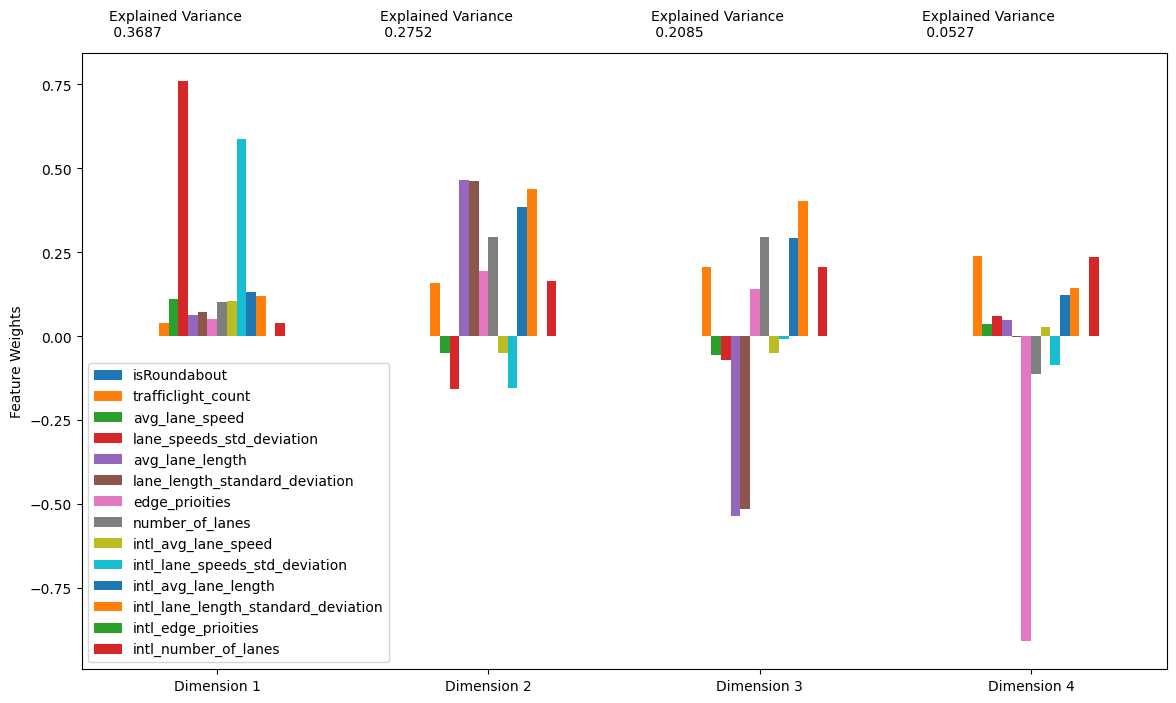

In [10]:
from sklearn.decomposition import PCA

def pca_analyse(dataset):
    pca = PCA(n_components=4).fit(dataset)
    pca_res = pca_results(dataset, pca)
    print(pca_res['Explained Variance'].cumsum())
print ("Analyzing LUST Dataset:")

pca_analyse (scaled_lust_dataset)

In [11]:
# Fit PCA to the good data using three dimensions
lst_pca =  PCA(n_components=3).fit(scaled_lust_dataset)

# Apply a PCA transformation the good data)
lst_reduced_data = lst_pca.transform(scaled_lust_dataset)

# Create DataFrames
reduced_scaled_lust_dataset = pd.DataFrame(lst_reduced_data, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])

In [12]:
from sklearn import mixture
from sklearn.metrics import silhouette_score

def apply_clustering(reduced_data):
    covar_types = ['spherical', 'diag', 'tied', 'full']
    covar_type = covar_types[3]
    scores=[]
    best_preds=None
    best_centers=None
    best_score=0
    for n in range(2,40):
        clusterer = mixture.GaussianMixture (n_components= n, covariance_type=covar_type, max_iter=100, random_state= 512*n).fit(reduced_data)
        preds = clusterer.predict(reduced_data)
        centers = clusterer.means_
        score = silhouette_score(reduced_data, preds, metric='euclidean')
        if score>best_score:
            best_score=score
            best_preds=preds
            best_centers=centers
            print("\tnew best cluster count {}".format(n))

        scores.append(score)
    return (best_preds,best_centers, scores)

In [13]:
print("3d clustering for lust...")
reduced_scaled_lust_dataset_clusters= apply_clustering(reduced_scaled_lust_dataset)

max_table= pd.DataFrame([[np.max(reduced_scaled_lust_dataset_clusters[2])]],columns=['lust_max'])

print("best values:")
display(max_table)
print("all values")
results_table= pd.DataFrame()
results_table["lust_scores"]=reduced_scaled_lust_dataset_clusters[2]
results_table.index= np.arange(2, len(results_table)+2)
display(results_table)

3d clustering for lust...
	new best cluster count 2
best values:


,lust_max
0,0.348489


all values


,lust_scores
2,0.348489
3,0.322795
4,0.285824
5,0.347807
6,0.205714
7,0.323425
8,0.187459
9,0.172807
10,0.159760
11,0.174368


In [14]:
colors=["#000000","#FFFF00","#1CE6FF","#FF34FF","#FF4A46","#008941","#006FA6","#A30059","#FFDBE5",
        "#7A4900","#0000A6","#63FFAC","#B79762","#004D43","#8FB0FF","#997D87","#5A0007","#809693",
        "#FEFFE6","#1B4400","#4FC601","#3B5DFF","#4A3B53","#FF2F80","#61615A","#BA0900","#6B7900",
        "#00C2A0","#FFAA92","#FF90C9","#B903AA","#D16100","#DDEFFF","#000035","#7B4F4B","#A1C299",
        "#300018","#0AA6D8","#013349","#00846F","#372101","#FFB500","#C2FFED","#A079BF","#CC0744",
        "#C0B9B2","#C2FF99","#001E09","#00489C","#6F0062","#0CBD66","#EEC3FF","#456D75","#B77B68",
        "#7A87A1","#788D66","#885578","#FAD09F","#FF8A9A","#D157A0","#BEC459","#456648","#0086ED",
        "#886F4C","#34362D","#B4A8BD","#00A6AA","#452C2C","#636375","#A3C8C9","#FF913F","#938A81",
        "#575329","#00FECF","#B05B6F","#8CD0FF","#3B9700","#04F757","#C8A1A1","#1E6E00","#7900D7",
        "#A77500","#6367A9","#A05837","#6B002C","#772600","#D790FF","#9B9700","#549E79","#FFF69F",
        "#201625","#72418F","#BC23FF","#99ADC0","#3A2465","#922329","#5B4534","#FDE8DC","#404E55",
        "#0089A3","#CB7E98","#A4E804","#324E72","#6A3A4C","#83AB58","#001C1E","#D1F7CE","#004B28",
        "#C8D0F6","#A3A489","#806C66","#222800","#BF5650","#E83000","#66796D","#DA007C","#FF1A59",
        "#8ADBB4","#1E0200","#5B4E51","#C895C5","#320033","#FF6832","#66E1D3","#CFCDAC","#D0AC94",
        "#7ED379","#012C58","#7A7BFF","#D68E01","#353339","#78AFA1","#FEB2C6","#75797C","#837393",
        "#943A4D","#B5F4FF","#D2DCD5","#9556BD","#6A714A","#001325","#02525F","#0AA3F7","#E98176",
        "#DBD5DD","#5EBCD1","#3D4F44","#7E6405","#02684E","#962B75","#8D8546","#9695C5","#E773CE",
        "#D86A78","#3E89BE","#CA834E","#518A87","#5B113C","#55813B","#E704C4","#00005F","#A97399",
        "#4B8160","#59738A","#FF5DA7","#F7C9BF","#643127","#513A01","#6B94AA","#51A058","#A45B02",
        "#1D1702","#E20027","#E7AB63","#4C6001","#9C6966","#64547B","#97979E","#006A66","#391406",
        "#F4D749","#0045D2","#006C31","#DDB6D0","#7C6571","#9FB2A4","#00D891","#15A08A","#BC65E9",
        "#FFFFFE","#C6DC99","#203B3C","#671190","#6B3A64","#F5E1FF","#FFA0F2","#CCAA35","#374527",
        "#8BB400","#797868","#C6005A","#3B000A","#C86240","#29607C","#402334","#7D5A44","#CCB87C",
        "#B88183","#AA5199","#B5D6C3","#A38469","#9F94F0","#A74571","#B894A6","#71BB8C","#00B433",
        "#789EC9","#6D80BA","#953F00","#5EFF03","#E4FFFC","#1BE177","#BCB1E5","#76912F","#003109",
        "#0060CD","#D20096","#895563","#29201D","#5B3213","#A76F42","#89412E","#1A3A2A","#494B5A",
        "#A88C85","#F4ABAA","#A3F3AB","#00C6C8","#EA8B66","#958A9F","#BDC9D2","#9FA064","#BE4700","#658188","#83A485","#453C23","#47675D","#3A3F00","#061203","#DFFB71","#868E7E","#98D058","#6C8F7D","#D7BFC2","#3C3E6E","#D83D66","#2F5D9B","#6C5E46","#D25B88","#5B656C","#00B57F","#545C46","#866097","#365D25","#252F99","#00CCFF","#674E60","#FC009C","#92896B"]


In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def show_3d_plot(reduced_data, centers, preds):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    n = 100
    for i,series in enumerate(reduced_data.iterrows()):
        p=preds[i]
        xs = series[1].get(0)
        ys = series[1].get(1)
        zs = series[1].get(2)

        ax.scatter(xs, ys, zs, c=colors[p])

    for i, series in enumerate(centers):
        ax.scatter(series[0],series[1],series[2], c = 'white', edgecolors = 'black', \
        alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(series[0],series[1],series[2], marker='$%d$'%(i), alpha = 1, s=100);

    ax.set_xlabel(reduced_data.columns[0])
    ax.set_ylabel(reduced_data.columns[1])
    ax.set_zlabel(reduced_data.columns[2])

    plt.show()

Lust- max_abs Scaler PCA 3 Dimension Clusters


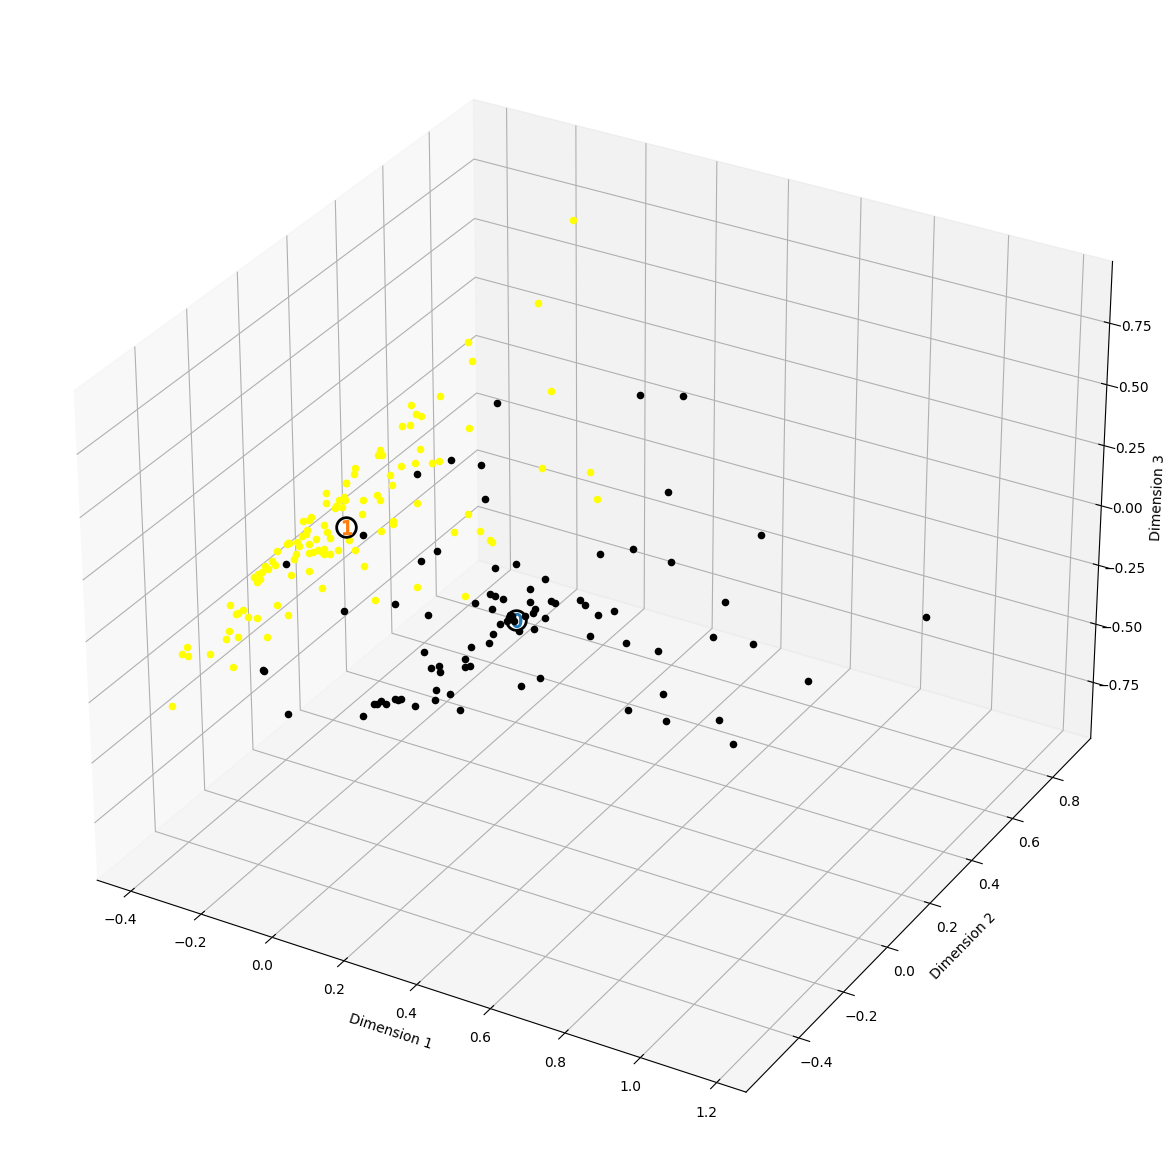

In [16]:
print("Lust- max_abs Scaler PCA 3 Dimension Clusters")
show_3d_plot(reduced_scaled_lust_dataset,reduced_scaled_lust_dataset_clusters[1],reduced_scaled_lust_dataset_clusters[0])

In [19]:
lust_raw_df= pd.read_csv(lust_file_name)
lust_raw_df.columns= copy.copy(columns)

clusters_maxabs_lust= reduced_scaled_lust_dataset_clusters[0]
lust_item_count= len(lust_raw_df)
lust_raw_df['clusters_maxabs_3dimensions']=clusters_maxabs_lust

lust_raw_df.to_csv("dataset-lust-tl-clusters.csv")